# HW11

## Tensor Exercises

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [ ]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [ ]:
import torch

from os import listdir, path
from torch import Tensor

from image_utils import make_image, open_image

## Tensor Steganography

Let's practice tensor manipulation and slicing by decoding some secret messages hidden in images.

Input images are always $1024$ x $512$ pixels and resulting images/messages are always $128$ x $128$ pixels.

### Example

Let's open the image at `./data/image/tensors/street.png`.

It's $1024$ x $512$ pixels and has a $128$ x $128$ pixel message encoded in its corners.

To decode this message, we have to extract $4$ smaller sections of the image, each of which is $64$ x $64$ pixels, and put these in a larger $128$ x $128$ tensor.

In [ ]:
# open and display image
street = open_image("./data/image/tensors/street.png")
display(street)

# turn it into a tensor, get dimensions from image
street_t = Tensor(street.pixels).reshape(street.size[1], street.size[0], -1)

In [ ]:
# since the resulting image is 128 x 128, we can grab a
# 128 x 128 section of the image to be the resulting image tensor

message_t = street_t[:128,:128]
display(make_image(message_t))

In [ ]:
# alternatively, we could start with an empty tensor of all zeros
# it just has to have the right dimensions and number of pixel channels
message_t = torch.zeros(128, 128, street_t.shape[-1])

message_t[:64, :64] = street_t[:64,:64]
display(make_image(message_t))

In [ ]:
# now we can finish grabbing the rest of the corners

# top 64 rows, right-most 64 columns
message_t[:64, -64:] = street_t[:64, -64:]
display(make_image(message_t))

In [ ]:
# bottom half
message_t[-64:, :64] = street_t[-64:, :64]
message_t[-64:, -64:] = street_t[-64:, -64:]
display(make_image(message_t))

### The messages

Ok. On to the messages.

In [ ]:
# A bit of pre-loading
forests = []
for f in sorted([f for f in listdir("./data/image/tensors") if f.endswith(".png")]):
  forests.append(open_image(path.join("./data/image/tensors", f)))

### Image 00

The message is barely hidden in the top $128$ rows and middle $128$ rows of the image.

To decode this message, extract its left half from evenly-spaced intervals on the top $128$ rows of the image, and its right half from the center $128$ rows.

We can add a stride to our slicing by specifying a number after the second `:`. For example, this slices a list by grabbing every other element: `my_list[::2]`. This would slice and grab every 7 $^{th}$ element `my_list[::7]`.

Since the input image is $1024$ pixels wide and we're getting $64$ evenly-spaced columns from these $1024$ columns, we should read every $\frac{1024}{64} = 16$ columns.

These can be extracted into two separate tensors of shape `(128, 64, 3)`, and then combined with the `torch.stack()` function:

`message = torch.stack((left_t, right_t), dim=1)`

In [ ]:
img_00.size

In [ ]:
right_t.shape

In [ ]:
# display image
img_00 = forests[0]
display(img_00)

# put into Tensor
img_00_t = Tensor(img_00.pixels).reshape(img_00.size[1], img_00.size[0], -1)

# TODO: get right and left halves
#       by reading 128 rows of 1 pixel columns every 16 columns
#left_t = torch.zeros(128, 64,3)    # need to change this to grab actual pixels
left_t = img_00_t[:128, ::16, :]
#right_t = torch.zeros(128, 64,3)   # need to change this to grab actual pixels
right_t = img_00_t[img_00.size[1]//2 - 64:img_00.size[1]//2 + 64, ::16, :]
# stack results
img_00_pxs = torch.stack((left_t, right_t), dim=1)

# display message
display(make_image(img_00_pxs))

### Image 01

The message is again hidden in evenly-spaced intervals, but this time its individual pixels are spread across the entire image.

To decode this message, extract evenly-spaced pixels from the image's rows and columns.

Since the input image is $1024$ pixels wide and we're getting $128$ evenly-spaced columns from these $1024$ columns, we should read every $\frac{1024}{128} = 8$ columns. For the rows, we should read every $\frac{512}{128} = 4$ rows.

In [ ]:
# display image
img_01 = forests[1]
display(img_01)

# TODO: put into Tensor
img_01_t = Tensor(img_01.pixels).reshape(img_01.size[1], img_01.size[0], -1)
# TODO: extract evenly-spaced pixels by
#       slicing the original image at every 8 columns and 4 rows.
#img_01_pxs = torch.zeros(128, 128) # change this
img_01_pxs = img_01_t[::4, ::8, :]
# display message
display(make_image(img_01_pxs))

### Image 02

The message is again hidden in evenly-spaced pixels, but this time its individual `R`, `G` and `B` values are divided into different pixels of the input image.

To extract the `R` components, read the `B` channel of evenly-spaced pixels starting at pixel $(0,0)$.

To extract the `G` components, read the `B` channel of evenly-spaced pixels starting at pixel $(1,1)$.

To extract the `B` components, read the `B` channel of evenly-spaced pixels starting at pixel $(2,2)$.

Those are not typos, the $3$ values are all hidden in the `B` channel of the source image.

The row and column strides (the length of the skips) is the same for all $3$ channels and should be the same as in the previous exercise.

You can extract each channel into $3$ separate images with shape $(128,128,1)$ or $(128,128)$, and then use `torch.stack((R,G,B), dim=2)` to combine them into one image.

In [ ]:
# display image
img_02 = forests[2]
display(img_02)

# TODO: put into Tensor
img_02_t = Tensor(img_02.pixels).reshape(img_02.size[1], img_02.size[0], -1)
# TODO: extract B value of evenly-spaced pixels starting at (0,0), (1,1) and (2,2)
img_02_R = img_02_t[::4, ::8, 2] # change this
img_02_G = img_02_t[1::4, 1::8, 2] # change this
img_02_B = img_02_t[2::4, 2::8, 2] # change this

# stack results along pixel dimension
img_02_pxs = torch.stack((img_02_R, img_02_G, img_02_B), dim=2)

# display message
display(make_image(img_02_pxs))

### Image 03

The message is hidden in the first $16\text{,}384$ pixels that have a luminance value above the image's average luminance value.

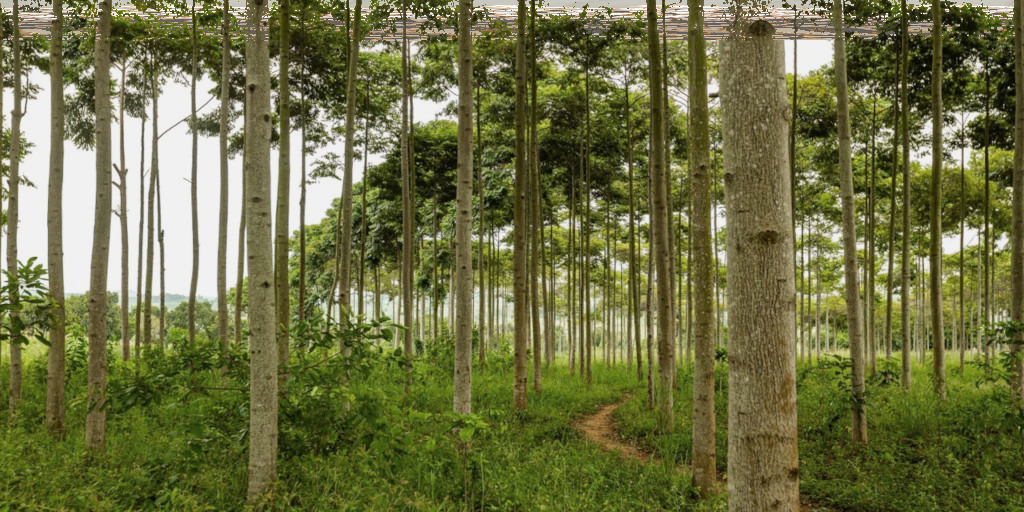

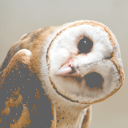

In [7]:
# display image
img_03 = forests[3]
display(img_03)

# TODO: put into Tensor
img_03_t = Tensor(img_03.pixels).reshape(img_03.size[1], img_03.size[0], -1)
# TODO: get grayscale image by averaging over dimension 2
img_03_gs_t = img_03_t.mean(2)
# TODO: get image's average luminance value
avg_luminance = img_03_gs_t.mean()
# TODO: extract pixels from the original image that have a corresponding luminance value above the image's average
#a boolean mask to see if the pixel above the avg
above_avg_luminance_pixels = img_03_gs_t > avg_luminance
luminance_pixels=img_03_t[above_avg_luminance_pixels,:]
# TODO: grab first 16,384 pixels
img_03_pxs = luminance_pixels[:16384]
# display message
display(make_image(img_03_pxs))

### Image 04

The message is hidden in the lowest $3$ bits of the $128$ x $128$ pixel area in the very center of the image.

You can first extract the pixels and then extract the bits, or, you can just extract the lowest $3$ bits of all pixels values in the image to see what happens.

One way to grab the lowest $3$ bits of a pixel is to get the remainder of a division by $8$ and then multiply that by $32$. If `pt` is a pixel tensor, we can do that with `(pt % 8) * 32`.

In [ ]:
# display image
img_04 = forests[4]
display(img_04)

# TODO: put into Tensor

# TODO: crop out center 128x128 pixels

# TODO: get lowest 3 bits of all pixels
img_04_pxs = torch.zeros(128, 128) # change this

# display message
display(make_image(img_04_pxs))